In [75]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
import matplotlib.pyplot as plt


In [76]:
# Load the dataset
data_path = '/Users/ahmedalkhulayfi/Documents/Stanford/Labs/project/G2 - Sheet1.csv'
df = pd.read_csv(data_path)
df

,Sample ID,Sample type,Source,AMI,AMI symbol,AMP,AMP symbol,CIP symbol,Target
0,1,PC,A,4.0,S,>=32,R,1,R
1,2,PC,A,4.0,S,>=32,R,1,R
2,3,PC,B,4.0,S,32,R,1,R
3,4,PC,B,4.0,S,32,R,0.5,I
4,5,PC,C,4.0,S,32,R,1,R
...,...,...,...,...,...,...,...,...,...
257,258,PC,A,4.0,S,>32,R,1,R
258,259,PC,A,4.0,S,>32,R,1=,R
259,260,PC,A,4.0,S,>32,R,1=,R
260,261,PC,A,4.0,S,>32,R,2=,R


# Dataset Summary

## Context
This dataset appears to represent data from **antimicrobial susceptibility testing (AST)**, a clinical or laboratory method to assess bacterial resistance or susceptibility to antibiotics. It includes information about different bacterial samples, antibiotics tested, and their resistance or susceptibility outcomes.

## Column Descriptions
| **Column Name**  | **Description**                                                                                  |
|-------------------|--------------------------------------------------------------------------------------------------|
| `Sample ID`       | A unique identifier for each bacterial sample or isolate.                                       |
| `Sample Type`     | Indicates the type or category of the sample (e.g., "PC" could represent "Patient Culture").    |
| `Source`          | The origin of the sample (e.g., anatomical site, hospital, or collection point).                |
| `AMI`             | MIC value (Minimum Inhibitory Concentration) for a specific antibiotic (e.g., Amikacin).        |
| `AMI Symbol`      | Interpreted susceptibility for the antibiotic (`S`=Susceptible, `R`=Resistant, `I`=Intermediate).|
| `AMP`             | MIC value for another antibiotic (e.g., Ampicillin).                                            |
| `AMP Symbol`      | Interpreted susceptibility for the antibiotic (`S`, `R`, `I`).                                  |
| `CIP Symbol`      | Interpreted susceptibility for another antibiotic (e.g., Ciprofloxacin).                        |
| `Target`          | Final classification of resistance or susceptibility for the isolate (`S`, `R`, `I`).           |

## Potential Use Cases
1. **Prediction of Antimicrobial Resistance (AMR):**
   - Build machine learning models to predict bacterial resistance based on test data.
   
2. **Optimizing Diagnostic Workflows:**
   - Identify relationships between partial test results and overall susceptibility to reduce testing time.

3. **Clinical Decision Support:**
   - Use the data to guide antibiotic selection based on resistance patterns.

## Notes
- Numeric MIC values (e.g., in `AMI`, `AMP`) need to be standardized (e.g., handling values like `>=32`).
- Symbols like `S`, `R`, and `I` represent categorical interpretations and should be encoded for ML tasks.
- Features like `Sample ID` may not add value for predictive modeling and could be excluded.

In [77]:
df["Sample type"].unique()
# Inspect the "Sample type" column
sample_type_info = {
    "unique_values": df["Sample type"].unique(),  # Check unique values
    "missing_values": df["Sample type"].isnull().sum(),# Check for missing values
    "value_counts" :df["Sample type"].value_counts()
}


# Print information about the column
print("Sample type information:")
print(sample_type_info)

# Apply One-Hot Encoding
df = pd.get_dummies(df, columns=["Sample type"], prefix="Sample", dtype=float)

# Check the result
df.head()

Sample type information:
{'unique_values': array(['PC', 'FCS', 'FC', 'FFC'], dtype=object), 'missing_values': 0, 'value_counts': Sample type
PC     218
FCS     33
FFC     10
FC       1
Name: count, dtype: int64}


,Sample ID,Source,AMI,AMI symbol,AMP,AMP symbol,CIP symbol,Target,Sample_FC,Sample_FCS,Sample_FFC,Sample_PC
0,1,A,4.0,S,>=32,R,1,R,0.0,0.0,0.0,1.0
1,2,A,4.0,S,>=32,R,1,R,0.0,0.0,0.0,1.0
2,3,B,4.0,S,32,R,1,R,0.0,0.0,0.0,1.0
3,4,B,4.0,S,32,R,0.5,I,0.0,0.0,0.0,1.0
4,5,C,4.0,S,32,R,1,R,0.0,0.0,0.0,1.0


In [78]:
# Inspect the "Source" column
source_info = {
    "unique_values": df["Source"].unique(),
    "missing_values": df["Source"].isnull().sum(),
    "value_counts" :df["Source"].value_counts()
}

# Print information about the column
print("Source information:")
print(source_info)

Source information:
{'unique_values': array(['A', 'B', 'C', 'D', 'E', 'F', 'Uknown', 'H', 'I', 'J', 'K', 'L',
       'M', 'Unknown', 'N', 'O', 'P', 'Q'], dtype=object), 'missing_values': 0, 'value_counts': Source
M          84
B          52
A          50
K          10
C           9
E           8
J           7
Q           7
Uknown      6
F           6
O           5
L           4
D           4
N           4
Unknown     3
H           1
I           1
P           1
Name: count, dtype: int64}


In [79]:
df["Source"] = df["Source"].replace({"Uknown": "Unknown"})

# Check the unique values after cleaning
print("Unique values after cleaning:", df["Source"].unique())

df = pd.get_dummies(df, columns=["Source"], prefix="Source", dtype= float)

# Check the result
df.head()

Unique values after cleaning: ['A' 'B' 'C' 'D' 'E' 'F' 'Unknown' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q']


,Sample ID,AMI,AMI symbol,AMP,AMP symbol,CIP symbol,Target,Sample_FC,Sample_FCS,Sample_FFC,...,Source_I,Source_J,Source_K,Source_L,Source_M,Source_N,Source_O,Source_P,Source_Q,Source_Unknown
0,1,4.0,S,>=32,R,1,R,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,4.0,S,>=32,R,1,R,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,4.0,S,32,R,1,R,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,4.0,S,32,R,0.5,I,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4.0,S,32,R,1,R,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
# Inspect the "AMI" column
ami_info = {
    "unique_values": df["AMI"].unique(),
    "missing_values": df["AMI"].isnull().sum(),
    "min_value": df["AMI"].min(),
    "max_value": df["AMI"].max(),
}

# Print column info
print("AMI column information:")
print(ami_info)

AMI column information:
{'unique_values': array([ 4., nan]), 'missing_values': 1, 'min_value': 4.0, 'max_value': 4.0}


In [81]:
# Drop the "AMI" column
df = df.drop(columns=["AMI"])

# Check the result
df.head()

,Sample ID,AMI symbol,AMP,AMP symbol,CIP symbol,Target,Sample_FC,Sample_FCS,Sample_FFC,Sample_PC,...,Source_I,Source_J,Source_K,Source_L,Source_M,Source_N,Source_O,Source_P,Source_Q,Source_Unknown
0,1,S,>=32,R,1,R,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,S,>=32,R,1,R,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,S,32,R,1,R,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,S,32,R,0.5,I,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,S,32,R,1,R,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
# Inspect the "AMI symbol" column
ami_symbol_info = {
    "unique_values": df["AMI symbol"].unique(),
    "missing_values": df["AMI symbol"].isnull().sum(), 
    "value_counts" :df["AMI symbol"].value_counts()
}


# Print column info
print("AMI symbol column information:")
print(ami_symbol_info)

AMI symbol column information:
{'unique_values': array(['S', nan, 'I'], dtype=object), 'missing_values': 1, 'value_counts': AMI symbol
S    260
I      1
Name: count, dtype: int64}


In [83]:
# Fill missing value with the mode (most frequent value)
df["AMI symbol"] = df["AMI symbol"].fillna(df["AMI symbol"].mode()[0])



# Verify there are no missing values
print("Missing values after filling:", df["AMI symbol"].isnull().sum())

# One-Hot Encode the "AMI symbol" column
df = pd.get_dummies(df, columns=["AMI symbol"], prefix="AMI_symbol", dtype=float)

# Check the result
df.head()

Missing values after filling: 0


,Sample ID,AMP,AMP symbol,CIP symbol,Target,Sample_FC,Sample_FCS,Sample_FFC,Sample_PC,Source_A,...,Source_K,Source_L,Source_M,Source_N,Source_O,Source_P,Source_Q,Source_Unknown,AMI_symbol_I,AMI_symbol_S
0,1,>=32,R,1,R,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,>=32,R,1,R,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3,32,R,1,R,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,32,R,0.5,I,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,32,R,1,R,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [84]:
amp_info = {
    "unique_values": df["AMP"].unique(),
    "missing_values": df["AMP"].isnull().sum(),
    "value_counts" :df["AMP"].value_counts()
}

# Print column info
print("AMP column information:")
print(amp_info)

AMP column information:
{'unique_values': array(['>=32', '32', '>32', '4', nan], dtype=object), 'missing_values': 1, 'value_counts': AMP
32      189
>=32     47
>32      24
4         1
Name: count, dtype: int64}


In [85]:
# Step 1: Fill Missing Values
df["AMP"] = df["AMP"].fillna(df["AMP"].mode()[0])

# Step 2: Parse Numerical Values and Add Binary Indicator
def preprocess_amp(value):
    if pd.isnull(value):  # Handle any remaining NaN
        return None, 0
    if ">=" in value:
        return float(value.replace(">=", "").strip()), 1  # Extract value, mark as ">="
    elif ">" in value:
        return float(value.replace(">", "").strip()), 2  # Extract value, mark as ">"
    else:
        return float(value), 0  # Regular numeric value, no special case

# Apply the function to split the column
df[["AMP_numeric", "AMP_special_case"]] = df["AMP"].apply(
    lambda x: pd.Series(preprocess_amp(x))
)

# Step 3: Verify the Result
df[["AMP", "AMP_numeric", "AMP_special_case"]].head()

,AMP,AMP_numeric,AMP_special_case
0,>=32,32.0,1.0
1,>=32,32.0,1.0
2,32,32.0,0.0
3,32,32.0,0.0
4,32,32.0,0.0


In [86]:
df = df.drop(columns=["AMP"])
df

,Sample ID,AMP symbol,CIP symbol,Target,Sample_FC,Sample_FCS,Sample_FFC,Sample_PC,Source_A,Source_B,...,Source_M,Source_N,Source_O,Source_P,Source_Q,Source_Unknown,AMI_symbol_I,AMI_symbol_S,AMP_numeric,AMP_special_case
0,1,R,1,R,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,1.0
1,2,R,1,R,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,1.0
2,3,R,1,R,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,0.0
3,4,R,0.5,I,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,0.0
4,5,R,1,R,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,258,R,1,R,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,2.0
258,259,R,1=,R,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,2.0
259,260,R,1=,R,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,2.0
260,261,R,2=,R,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32.0,2.0


In [87]:
# Inspect the "AMP symbol" column
amp_symbol_info = {
    "unique_values": df["AMP symbol"].unique(),
    "missing_values": df["AMP symbol"].isnull().sum()
}

# Print column info
print("AMP symbol column information:")
print(amp_symbol_info)

AMP symbol column information:
{'unique_values': array(['R', 'S', nan], dtype=object), 'missing_values': 1}


In [88]:
df["AMP symbol"] = df["AMP symbol"].fillna(df["AMP symbol"].mode()[0])

# OR treat as a new category
# df["AMP symbol"] = df["AMP symbol"].fillna("Unknown")

# Verify no missing values
print("Missing values after filling:", df["AMP symbol"].isnull().sum())


# One-Hot Encode the "AMP symbol" column
df = pd.get_dummies(df, columns=["AMP symbol"], prefix="AMP_symbol" , dtype=float)

# Check the result
df.head()

Missing values after filling: 0


,Sample ID,CIP symbol,Target,Sample_FC,Sample_FCS,Sample_FFC,Sample_PC,Source_A,Source_B,Source_C,...,Source_O,Source_P,Source_Q,Source_Unknown,AMI_symbol_I,AMI_symbol_S,AMP_numeric,AMP_special_case,AMP_symbol_R,AMP_symbol_S
0,1,1,R,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,32.0,1.0,1.0,0.0
1,2,1,R,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,32.0,1.0,1.0,0.0
2,3,1,R,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,32.0,0.0,1.0,0.0
3,4,0.5,I,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,32.0,0.0,1.0,0.0
4,5,1,R,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,32.0,0.0,1.0,0.0


In [89]:
# Inspect the "CIP symbol" column
cip_symbol_info = {
    "unique_values": df["CIP symbol"].unique(),
    "missing_values": df["CIP symbol"].isnull().sum(), 
    "count_values" : df["CIP symbol"].value_counts()
}

# Print column info
print("CIP symbol column information:")
print(cip_symbol_info)

CIP symbol column information:
{'unique_values': array(['1', '0.5', '0.25', '<=0.015', '2', '4', '1=', '8=', '>8', '2=',
       '0.5=', '0.25=', '0.12', nan, '0.03', '0.06='], dtype=object), 'missing_values': 1, 'count_values': CIP symbol
0.5        104
1           88
2           18
<=0.015     16
1=          13
2=           7
0.25         4
0.03         3
4            2
8=           1
>8           1
0.5=         1
0.25=        1
0.12         1
0.06=        1
Name: count, dtype: int64}


In [90]:
# Step 1: Fill Missing Values
df["CIP symbol"] = df["CIP symbol"].fillna(df["CIP symbol"].mode()[0])

# Step 2: Parse Numeric and Special Case
def preprocess_cip(value):
    if "<=" in value:
        return float(value.replace("<=", "").strip()), -1  # Less-than-or-equal
    if ">" in value:
        return float(value.replace(">", "").strip()), 1  # Greater-than
    if "=" in value:
        return float(value.replace("=", "").strip()), 2  # Exact match
    try:
        return float(value), 0  # Regular numeric value
    except ValueError:
        return None, 0  # Unexpected cases

# Apply parsing to extract numeric and special case
df[["CIP_numeric", "CIP_special_case"]] = df["CIP symbol"].apply(
    lambda x: pd.Series(preprocess_cip(x))
)
print(df["CIP_numeric"].unique())
# Step 3: Verify the Result
df[["CIP symbol", "CIP_numeric", "CIP_special_case"]].head(35)

[1.    0.5   0.25  0.015 2.    4.    8.    0.12  0.03  0.06 ]


,CIP symbol,CIP_numeric,CIP_special_case
0,1,1.000,0.0
1,1,1.000,0.0
2,1,1.000,0.0
3,0.5,0.500,0.0
4,1,1.000,0.0
5,1,1.000,0.0
6,0.25,0.250,0.0
7,<=0.015,0.015,-1.0
8,<=0.015,0.015,-1.0
9,<=0.015,0.015,-1.0


In [91]:
df = df.drop(columns=["CIP symbol"])
df

,Sample ID,Target,Sample_FC,Sample_FCS,Sample_FFC,Sample_PC,Source_A,Source_B,Source_C,Source_D,...,Source_Q,Source_Unknown,AMI_symbol_I,AMI_symbol_S,AMP_numeric,AMP_special_case,AMP_symbol_R,AMP_symbol_S,CIP_numeric,CIP_special_case
0,1,R,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,32.0,1.0,1.0,0.0,1.0,0.0
1,2,R,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,32.0,1.0,1.0,0.0,1.0,0.0
2,3,R,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,32.0,0.0,1.0,0.0,1.0,0.0
3,4,I,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,32.0,0.0,1.0,0.0,0.5,0.0
4,5,R,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,32.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,258,R,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,32.0,2.0,1.0,0.0,1.0,0.0
258,259,R,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,32.0,2.0,1.0,0.0,1.0,2.0
259,260,R,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,32.0,2.0,1.0,0.0,1.0,2.0
260,261,R,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,32.0,2.0,1.0,0.0,2.0,2.0


In [92]:
df = df.drop(columns=["Sample ID"])

print("Unique values in Target:", df["Target"].unique())
print("Value counts in Target:\n", df["Target"].value_counts())
df["Target"].isnull().sum()

Unique values in Target: ['R' 'I' 'S' 'NOINTP' nan]
Value counts in Target:
 Target
R         130
I         106
S          23
NOINTP      1
Name: count, dtype: int64


2

In [93]:
# Drop row with 'NOINTP' if it's an anomaly
df = df[df["Target"] != "NOINTP"]

# Fill missing values with the most frequent category ('R') or 'Unknown'
df["Target"] = df["Target"].fillna("R")  # Or replace "R" with "Unknown" as needed

# Check the updated distribution
print("Updated Target value counts:")
print(df["Target"].value_counts())

Updated Target value counts:
Target
R    132
I    106
S     23
Name: count, dtype: int64


In [94]:
label_encoder = LabelEncoder()
df["Target_encoded"] = label_encoder.fit_transform(df["Target"])

# Map the encoded values back to the original categories
target_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Encoding Mapping:", target_mapping)

# Drop the original Target column if only encoded values are needed
df = df.drop(columns=["Target"])
df

Encoding Mapping: {'I': 0, 'R': 1, 'S': 2}


,Sample_FC,Sample_FCS,Sample_FFC,Sample_PC,Source_A,Source_B,Source_C,Source_D,Source_E,Source_F,...,Source_Unknown,AMI_symbol_I,AMI_symbol_S,AMP_numeric,AMP_special_case,AMP_symbol_R,AMP_symbol_S,CIP_numeric,CIP_special_case,Target_encoded
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,32.0,1.0,1.0,0.0,1.0,0.0,1
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,32.0,1.0,1.0,0.0,1.0,0.0,1
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,32.0,0.0,1.0,0.0,1.0,0.0,1
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,32.0,0.0,1.0,0.0,0.5,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,32.0,0.0,1.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,32.0,2.0,1.0,0.0,1.0,0.0,1
258,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,32.0,2.0,1.0,0.0,1.0,2.0,1
259,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,32.0,2.0,1.0,0.0,1.0,2.0,1
260,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,32.0,2.0,1.0,0.0,2.0,2.0,1


In [95]:
# Save the DataFrame to a CSV file
output_path = "preprocessed_data_v2.csv"
df.to_csv(output_path, index=False)  # Set index=False to exclude the index column

print(f"File saved as {output_path}")

File saved as preprocessed_data_v2.csv


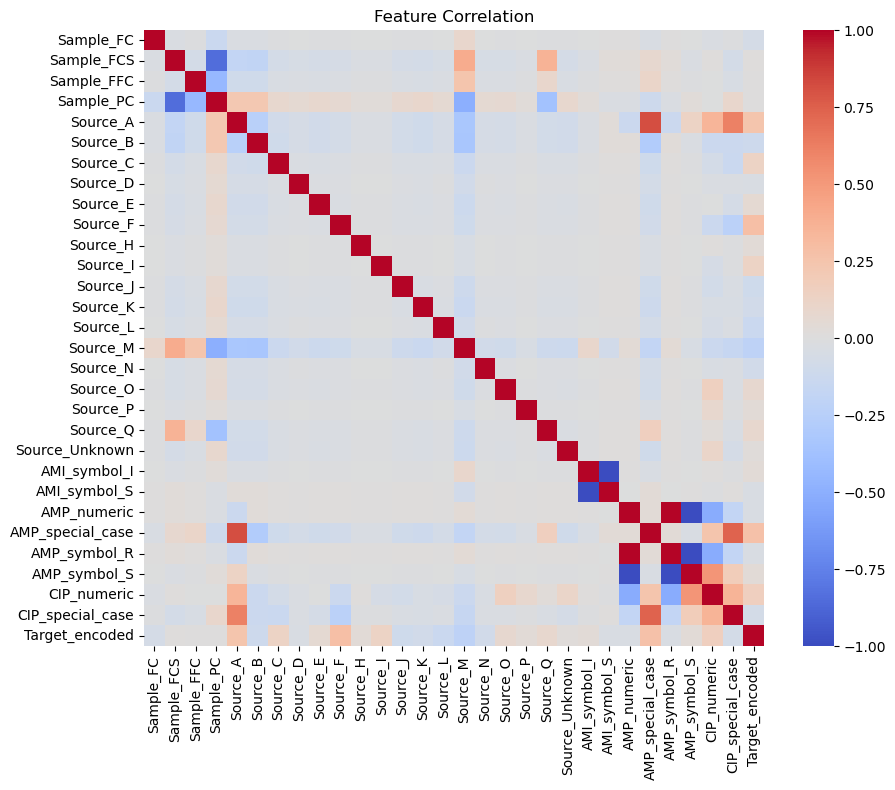

In [96]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

# Build  a base model

In [97]:
from sklearn.model_selection import train_test_split

preprocessed_data = pd.read_csv("/Users/ahmedalkhulayfi/Documents/Stanford/Labs/project/preprocessed_data_v2.csv")
# Features and target
X = preprocessed_data.drop(columns=["Target_encoded"])
y = preprocessed_data["Target_encoded"]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [99]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Accuracy: 0.9433962264150944

Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95        26
           1       1.00      0.96      0.98        23
           2       1.00      0.50      0.67         4

    accuracy                           0.94        53
   macro avg       0.97      0.82      0.86        53
weighted avg       0.95      0.94      0.94        53



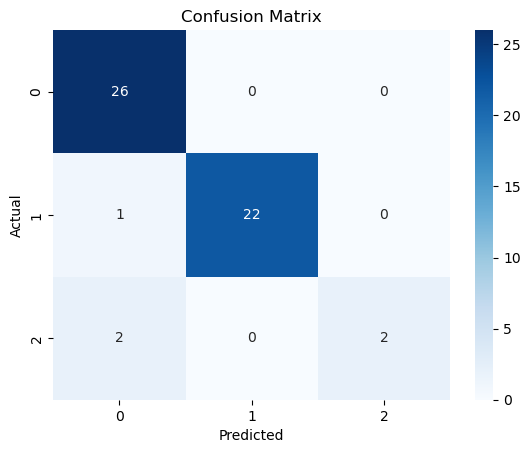

In [100]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Optional: Display confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Now GNN

In [101]:
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [102]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index  # Node features and edges
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Log-softmax for classification

# using kneighbors_graph

In [103]:
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch

# Step 1: Prepare features and labels
X = preprocessed_data.drop(columns=["Target_encoded"]).values  # Features
y = preprocessed_data["Target_encoded"].values  # Labels

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert features and labels to PyTorch tensors
node_features = torch.tensor(X_scaled, dtype=torch.float)
node_labels = torch.tensor(y, dtype=torch.long)

# Step 2: Define edges based on KNN or domain knowledge
from sklearn.neighbors import kneighbors_graph

k = 5  # Number of neighbors
adj_matrix = kneighbors_graph(X_scaled, n_neighbors=k, mode="connectivity", include_self=False)
edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

# Step 3: Create the PyTorch Geometric Data object
data = Data(x=node_features, edge_index=edge_index, y=node_labels)
print(edge_index.shape)

torch.Size([2, 1305])


In [104]:
# Define train/test/val masks

num_nodes = data.num_nodes
train_ratio, val_ratio, test_ratio = 0.7, 0.1, 0.2

# Randomly shuffle nodes
indices = torch.randperm(num_nodes)
train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[indices[:train_size]] = True
val_mask[indices[train_size:train_size + val_size]] = True
test_mask[indices[train_size + val_size:]] = True

# Add masks to the data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

# Hyperparameters
input_dim = data.num_node_features
hidden_dim = 16
output_dim = len(torch.unique(data.y))
learning_rate = 0.01
weight_decay = 5e-4
max_epochs = 1000
patience = 100

model = GCN(input_dim, hidden_dim, output_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Add LR Cosine Annealing
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

criterion = torch.nn.CrossEntropyLoss()

def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        loss = criterion(out[mask], data.y[mask])
        preds = out[mask].argmax(dim=1)
        accuracy = (preds == data.y[mask]).sum().item() / mask.sum().item()
    return loss.item(), accuracy

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(max_epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    train_loss = criterion(out[data.train_mask], data.y[data.train_mask])
    train_loss.backward()
    optimizer.step()

    # Step the scheduler after optimizer step
    scheduler.step()

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate(model, data, data.val_mask)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break

    if epoch % 10 == 0:
        train_preds = out[data.train_mask].argmax(dim=1)
        train_accuracy = (train_preds == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
        current_lr = scheduler.get_last_lr()[0]
        print(
            f"Epoch: {epoch}, LR: {current_lr:.6f}, "
            f"Train Loss: {train_loss.item():.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
        )

# Load the best model state
model.load_state_dict(best_model_state)


Epoch: 0, LR: 0.010000, Train Loss: 1.5061, Train Acc: 0.2692, Val Loss: 1.6950, Val Acc: 0.2692
Epoch: 10, LR: 0.009997, Train Loss: 0.6485, Train Acc: 0.6868, Val Loss: 0.7450, Val Acc: 0.7308
Epoch: 20, LR: 0.009989, Train Loss: 0.5152, Train Acc: 0.7912, Val Loss: 0.5583, Val Acc: 0.7692
Epoch: 30, LR: 0.009976, Train Loss: 0.4334, Train Acc: 0.8681, Val Loss: 0.4896, Val Acc: 0.8077
Epoch: 40, LR: 0.009959, Train Loss: 0.3672, Train Acc: 0.8846, Val Loss: 0.4172, Val Acc: 0.8077
Epoch: 50, LR: 0.009936, Train Loss: 0.3142, Train Acc: 0.8846, Val Loss: 0.3504, Val Acc: 0.8462
Epoch: 60, LR: 0.009908, Train Loss: 0.2735, Train Acc: 0.9176, Val Loss: 0.3140, Val Acc: 0.8462
Epoch: 70, LR: 0.009876, Train Loss: 0.2410, Train Acc: 0.9286, Val Loss: 0.2900, Val Acc: 0.8462
Epoch: 80, LR: 0.009839, Train Loss: 0.2137, Train Acc: 0.9341, Val Loss: 0.2814, Val Acc: 0.8462
Epoch: 90, LR: 0.009797, Train Loss: 0.1896, Train Acc: 0.9615, Val Loss: 0.2723, Val Acc: 0.8846
Epoch: 100, LR: 0.009

<All keys matched successfully>

Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      0.92      0.96        25
           2       0.83      1.00      0.91         5

    accuracy                           0.96        53
   macro avg       0.93      0.97      0.95        53
weighted avg       0.97      0.96      0.96        53

Confusion Matrix:
 [[23  0  0]
 [ 1 23  1]
 [ 0  0  5]]


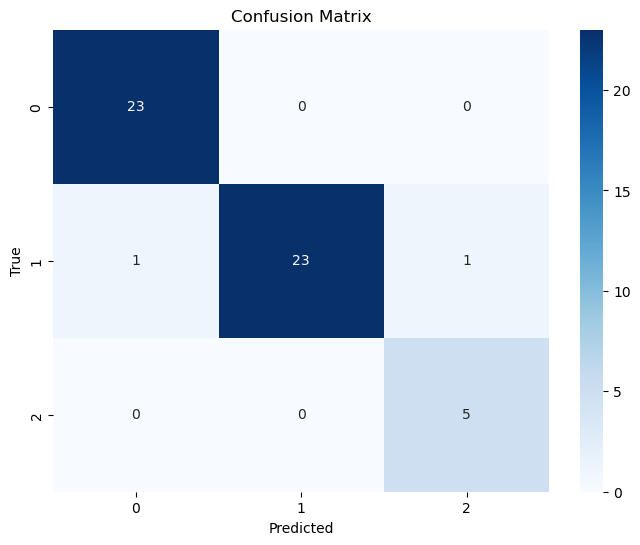

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model
model.eval()
with torch.no_grad():
    out = model(data)  # Forward pass
    test_preds = out[data.test_mask].argmax(dim=1).cpu().numpy()  # Predicted labels
    test_labels = data.y[data.test_mask].cpu().numpy()  # True labels

    # Classification report
    report = classification_report(test_labels, test_preds, target_names=[str(i) for i in range(output_dim)])
    print("Classification Report:\n", report)

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(output_dim)], yticklabels=[str(i) for i in range(output_dim)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

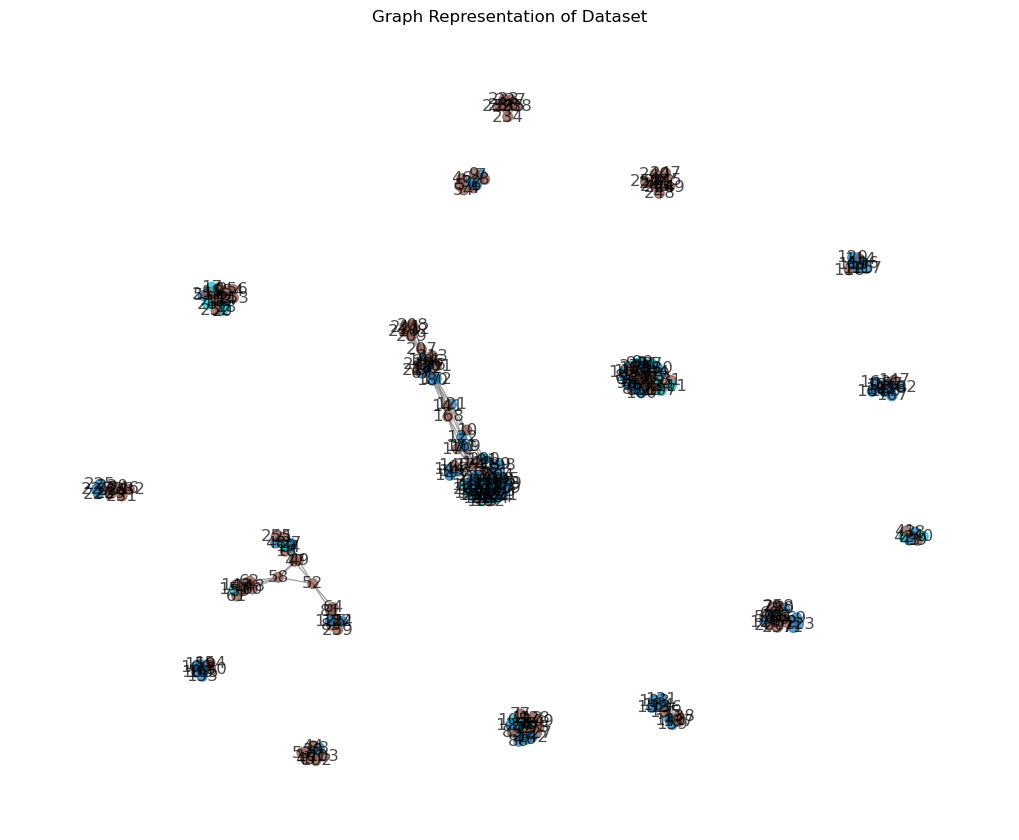

In [107]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert PyTorch Geometric data to NetworkX
G = nx.Graph()
edge_index = data.edge_index.numpy()  # Convert edges to NumPy array
G.add_edges_from(edge_index.T)  # Add edges
G.add_nodes_from(range(data.num_nodes))  # Add nodes

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Generate layout
nx.draw(
    G,
    pos,
    node_color=data.y.numpy(),  # Use labels to color nodes
    cmap=plt.cm.tab10,  # Color map for distinct classes
    with_labels=True,
    node_size=50,
    edge_color="gray",
    alpha=0.7
)
plt.title("Graph Representation of Dataset")
plt.show()